In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Importing Libraries

In [ ]:
import numpy as np
import sklearn
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble,tree,linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier,GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,cross_val_score
import tensorflow as tf
import warnings
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

py.init_notebook_mode(connected=True)
%reload_ext autoreload
%autoreload 2
%matplotlib inline
warnings.filterwarnings('ignore')

pd.options.display.max_columns=99

##Importing Dataset

In [ ]:
Input_Data = pd.read_csv('/content/drive/My Drive/NCI /Alzheimer/data/TADPOLE_InputData.csv')
Input_Data.head()

,PTID_Key,EXAMDATE,DX_bl,DXCHANGE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,...,AD_SCR_R_DTIROI_04_30_14,AD_PCR_L_DTIROI_04_30_14,AD_PCR_R_DTIROI_04_30_14,AD_CGC_L_DTIROI_04_30_14,AD_CGC_R_DTIROI_04_30_14,AD_CGH_L_DTIROI_04_30_14,AD_CGH_R_DTIROI_04_30_14,AD_FX_ST_L_DTIROI_04_30_14,AD_FX_ST_R_DTIROI_04_30_14,AD_SLF_L_DTIROI_04_30_14,AD_SLF_R_DTIROI_04_30_14,AD_SFO_L_DTIROI_04_30_14,AD_SFO_R_DTIROI_04_30_14,AD_IFO_L_DTIROI_04_30_14,AD_IFO_R_DTIROI_04_30_14,AD_SS_L_DTIROI_04_30_14,AD_SS_R_DTIROI_04_30_14,AD_EC_L_DTIROI_04_30_14,AD_EC_R_DTIROI_04_30_14,AD_UNC_L_DTIROI_04_30_14,AD_UNC_R_DTIROI_04_30_14,AD_FX_L_DTIROI_04_30_14,AD_FX_R_DTIROI_04_30_14,AD_GCC_L_DTIROI_04_30_14,AD_GCC_R_DTIROI_04_30_14,AD_BCC_L_DTIROI_04_30_14,AD_BCC_R_DTIROI_04_30_14,AD_SCC_L_DTIROI_04_30_14,AD_SCC_R_DTIROI_04_30_14,AD_RLIC_L_DTIROI_04_30_14,AD_RLIC_R_DTIROI_04_30_14,AD_TAP_L_DTIROI_04_30_14,AD_TAP_R_DTIROI_04_30_14,AD_SUMGCC_DTIROI_04_30_14,AD_SUMBCC_DTIROI_04_30_14,AD_SUMSCC_DTIROI_04_30_14,AD_SUMCC_DTIROI_04_30_14,AD_SUMFX_DTIROI_04_30_14,update_stamp_DTIROI_04_30_14,EXAMDATE_UPENNBIOMK9_04_19_17,PHASE_UPENNBIOMK9_04_19_17,BATCH_UPENNBIOMK9_04_19_17,KIT_UPENNBIOMK9_04_19_17,STDS_UPENNBIOMK9_04_19_17,RUNDATE_UPENNBIOMK9_04_19_17,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,COMMENT_UPENNBIOMK9_04_19_17
0,400.0,9/8/05,CN,1.0,74.3,Male,16.0,Not Hisp/Latino,White,Married,0.0,1.36926,NaN,NaN,0.0,10.67,18.67,28.0,44.0,4.0,6.0,54.5455,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NL,9/8/05,0.0,10.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,564.0,9/12/05,AD,3.0,81.3,Male,18.0,Not Hisp/Latino,White,Married,1.0,1.09079,NaN,NaN,4.5,22.00,31.00,20.0,22.0,1.0,4.0,100.0000,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,Dementia,9/12/05,4.5,22.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9/12/05,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,12/14/16,741.5,239.7,22.83,NaN
2,564.0,3/13/06,AD,3.0,81.3,Male,18.0,Not Hisp/Latino,White,Married,1.0,1.06360,NaN,NaN,6.0,19.00,30.00,24.0,19.0,2.0,6.0,100.0000,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88580.0,5446.0,1100060.0,2427.0,14400.0,16972.0,1906430.0,Dementia,9/12/05,4.5,22.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,564.0,9/12/06,AD,3.0,81.3,Male,18.0,Not Hisp/Latino,White,Married,1.0,1.10384,NaN,NaN,3.5,24.00,35.00,17.0,31.0,2.0,7.0,100.0000,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90099.0,5157.0,1095640.0,1596.0,14617.0,17330.0,1903820.0,Dementia,9/12/05,4.5,22.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9/13/06,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,12/14/16,601.4,251.7,24.18,NaN
4,564.0,9/12/07,AD,3.0,81.3,Male,18.0,Not Hisp/Latino,White,Married,1.0,1.03871,NaN,NaN,8.0,25.67,37.67,19.0,23.0,1.0,5.0,100.0000,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97420.0,5139.0,1088560.0,1175.0,14033.0,16398.0,1903420.0,Dementia,

## Data Cleaning by dropping constant value coloumns

In [ ]:
#Dropping coloumns with mostly unique constant values


# format date, drop constant columns + null PTID rows
def Input_prep(data):
    data['EXAMDATE'] = pd.to_datetime(data['EXAMDATE'], errors='coerce')
    data['EXAMDATE_bl'] = pd.to_datetime(data['EXAMDATE_bl'])
    
    # We will remove all columns where we have a unique value (constants)
    # It is useful because this columns don't give us none information
    discovering_consts = [col for col in data.columns if data[col].nunique() == 1]
    # printing the total of columns dropped 
    print(len(discovering_consts),"columns are dropped ")
    # Get the shape of the processed dataset
    data = data.drop(discovering_consts,axis=1)
    print("After dropping constants, the shape of the data set is:",data.shape)
    
    data=data.dropna(subset=['PTID_Key'])
    print("After dropping missing PTID_Key, the shape of the dataset is: ", data.shape)
    return data




###Dropping Coloumns with null values more than 60% threshold

In [ ]:
# Drop most null columns, threshold in %
def drop_maj(data, threshold):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    most_nan= [idx for idx in df[~(df['Total'] == 0)].index if df[~(df['Total'] == 0)].loc[idx,'Percent']>threshold]
    print("There are ", len(most_nan),"columns with ",threshold, "% missing values")
    data = data.drop(most_nan,axis=1)
    print("After dropping most null columns, the shape of the dataset is: ", data.shape)
    
    return data


In [ ]:
Input_Data=Input_prep(Input_Data)
Input_Data = drop_maj(Input_Data,60)

166 columns are dropped 
After dropping constants, the shape of the data set is: (8717, 1726)
After dropping missing PTID_Key, the shape of the dataset is:  (8715, 1726)
There are  1010 columns with  60 % missing values
After dropping most null columns, the shape of the dataset is:  (8715, 716)


In [ ]:
Input_Data['DX_bl'].isnull().sum()

0

In [ ]:
list = np.unique(Input_Data['DXCHANGE'].values)
list

array([ 1.,  2.,  3., ..., nan, nan, nan])

### Encoding Alzheimer stages into AD,CN,MCI

In [ ]:
# Get diagnosis of every visit based on DX_bl and DXCHANGE, then keep DX and drop the other two variables
def get_DX(Input_new):
    idx0 = Input_new.loc[Input_new['DXCHANGE'].isin([-1,1, 2, 3])].index.values 
    for ix0 in idx0:
            Input_new.loc[ix0,'DX'] = Input_new.loc[ix0,'DX_bl']

    idx1 = Input_new.loc[Input_new['DXCHANGE'].isin([4, 8])].index.values 
    for ix1 in idx1:
            Input_new.loc[ix1,'DX'] = 'EMCI'

    idx2 = Input_new.loc[Input_new['DXCHANGE'].isin([5, 6])].index.values 
    for ix2 in idx2:
            Input_new.loc[ix2,'DX'] = 'AD'

    idx3 = Input_new.loc[Input_new['DXCHANGE'].isin([7, 9])].index.values 
    for ix3 in idx3:
            Input_new.loc[ix3,'DX'] = 'CN'
    Input_new['DX']=Input_new['DX'].fillna(Input_new['DX_bl'])        
    print(Input_new['DX_bl'].isnull().sum())
    print(Input_new['DXCHANGE'].isnull().sum())
    print(Input_new['DX'].isnull().sum().sum())
    list = np.unique(Input_new['DX'].values)
    print(list)
    d={'SMC': 'CN','CN':'CN','AD':'AD','EMCI': 'MCI','LMCI':'MCI','MCI':'MCI'}
    Input_new['DX']=Input_new['DX'].map(d)
    print(Input_new['DX'].isnull().sum().sum())
    list = np.unique(Input_new['DX'].values)
    print(list)
    
    Input_new.head()
    
    return Input_new

In [ ]:
Input=get_DX(Input_Data)
print(Input.shape)
Input=Input.drop(['DX_bl','DXCHANGE'],axis=1)
print(Input.shape)

0
2399
0
['AD' 'CN' 'EMCI' 'LMCI' 'SMC']
0
['AD' 'CN' 'MCI']
(8715, 716)
(8715, 714)


### Filling missing values using Interpolation 

In [ ]:
# Perform linear interpolation, then ffil and bfil
def linear_interp(data):
    ID_list = np.unique(data.PTID_Key.values)
    # Create an empty dataframe with all columns from data
    Input_new=pd.DataFrame(columns=data.columns)

    for ID in ID_list:
        if ID/100==0:
            print(ID/len(ID_list), "% done processing")
        df=data[data['PTID_Key']==ID]
        # interpolate only for numeric data
        df=df.interpolate()
        # ffill, bfill numeric data that can't be interpolate as well as categorical data
        df=df.fillna(method='ffill')
        df=df.fillna(method='bfill')
        Input_new=pd.concat([Input_new, df], ignore_index=True)

    print("Remaining missing values: ", Input_new.isnull().sum().sum() )
    print("Filled percentage: ", (1- Input_new.isnull().sum().sum()/data.isnull().sum().sum())*100,"%")
    return Input_new

In [ ]:
def interp(data):
    # Sort data by PTID_Key and EXAMDATE
    data = data.sort_values(by=['PTID_Key','EXAMDATE'])
    
    # Total missing values, if want to get missing values of each column, delete the last sum()
    print("Total missing values: ", data.isnull().sum().sum())
    
    # Linear interpolation, then ffil, bfil
    data_new=linear_interp(data)
#     print(data_new.head())
    
    return data_new

In [ ]:
Input_proc=interp(Input)
Input=Input_proc
Input_proc.head()

Total missing values:  2526602
Remaining missing values:  740603
Filled percentage:  70.68778541297759 %


,PTID_Key,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,FDG_bl,Years_bl,Month_bl,Month,M,EXAMDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,...,ST83TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST86SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST88SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST89SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST8SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST96SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST9SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,update_stamp_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
0,1.0,2010-12-10,81.6,Male,13.0,Not Hisp/Latino,White,Married,1.0,1.50,14.00,21.00,27.0,28.0,3.0,3.0,50.00000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,MCI,2010-12-10,1.5,14.00,21.00,27.0,28.0,3.0,3.0,50.0000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,0.97265,0.000000,0.00000,0.0,0.0,11/4/10,...,2.858,0.911,808.0,274.0,2.435,0.549,6447.0,2768.0,2.079,0.689,NaN,3122.0,650.0,4.0,10571.0,4681.0,2.060,0.602,8067.0,2808.0,2.457,0.724,1829.0,722.0,2.457,0.941,8412.0,3696.0,1.929,0.652,5642.0,2293.0,2.460,0.764,13389.0,5166.0,2500.0,1.809,0.708,3490.0,1497.0,2.072,0.648,7240.0,2625.0,2.388,0.713,2385.0,18:26.0
1,1.0,2011-04-07,81.6,Male,13.0,Not Hisp/Latino,White,Married,1.0,2.25,15.50,23.50,25.5,27.0,2.5,4.0,66.66665,3.0,30302.0,6314.0,909689.0,3635.0,14620.0,14899.0,1331790.0,MCI,2010-12-10,1.5,14.00,21.00,27.0,28.0,3.0,3.0,50.0000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,0.97265,0.323066,3.86885,3.0,3.0,4/7/11,...,2.689,0.889,909.0,269.0,2.794,0.524,7143.0,2758.0,2.260,0.716,NaN,3082.0,574.0,4.0,11647.0,4623.0,2.257,0.584,8174.0,2697.0,2.562,0.740,1750.0,743.0,2.347,0.862,8447.0,3667.0,2.009,0.619,5709.0,2137.0,2.516,0.733,13537.0,5073.0,2503.0,1.806,0.677,3802.0,1484.0,2.326,0.676,7461.0,2435.0,2.529,0.734,2195.0,18:26.0
2,1.0,2011-09-08,81.6,Male,13.0,Not Hisp/La

In [ ]:
# Sort data by PTID and EXAMDATE, perform linear interpolatioin, then ffil, bfill, 
# then fill the rest with the same DX_bl category
def fill_null(data_new):

    null_col=data_new.columns[data_new.isnull().any()].tolist()
    categ=data_new.select_dtypes(exclude=["number","datetime"])
    categ_col=categ.columns[categ.isnull().any()].tolist()
    num=data_new.select_dtypes(exclude=["object","datetime"])
    num_col=num.columns[num.isnull().any()].tolist()
    print("Number of columns with missing values is: ",len(null_col))
    print("Number of numerical columns with missing values is: ",len(num_col))
    print("Number of categorical columns with missing values is: ",len(categ_col))
    # Create an empty dataframe with all columns from data_data
    print(data_new.shape)
    for col in num_col:
        
        data_new[col] = data_new.groupby(['DX'])[col].transform(lambda x: x.fillna(x.mean()))
    for col2 in categ_col:

        data_new[col2] = data_new.groupby(['DX'])[col2].transform(lambda x: x.fillna(x.value_counts().index[0]))

    print("Total number of missing values: ", data_new.isnull().sum().sum())
    print("shape of the dataset: ",data_new.shape)
    return data_new

In [ ]:
Input_new=fill_null(Input)

Number of columns with missing values is:  696
Number of numerical columns with missing values is:  677
Number of categorical columns with missing values is:  19
(8715, 714)
Total number of missing values:  0
shape of the dataset:  (8715, 714)


In [ ]:
Input_new.head()
Input_new['DX'].head()

0     MCI
1     MCI
2     MCI
3      AD
4      AD
5      AD
6      AD
7      CN
8      CN
9      CN
10     CN
11     CN
12     CN
13     CN
14     AD
15     CN
16     CN
17     CN
18     CN
19     CN
20     CN
21     CN
22     CN
23     CN
24     CN
25     CN
26     CN
27     CN
28     CN
29     CN
Name: DX, dtype: object

###Exporting Cleaned data

In [ ]:
Input_new.to_csv('/content/drive/My Drive/NCI /Alzheimer/data/Input_interp_filledCat.csv',index=False)

##Encoding Categorical coloumns

In [ ]:
# Category columns type is: object

categ_col=Input_new.select_dtypes(exclude=["number","datetime"]).columns.tolist()
print(categ_col)

for col in categ_col:
    Input_new[col]=Input_new[col].astype('category')
    Input_new[col] = Input_new[col].cat.codes
Input_new.head()

['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'DX', 'EXAMDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16', 'VERSION_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16', 'RUNDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16', 'STATUS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16', 'update_stamp_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16', 'EXAMDATE_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'VERSION_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'RUNDATE_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'STATUS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'OVERALLQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'TEMPQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'FRONTQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'PARQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'INSULAQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'OCCQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'BGQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'CWMQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'VENTQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'update_stamp_UCSFFSX_11_02_15_UCSFFSX51_08_01_16']


,PTID_Key,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,FDG_bl,Years_bl,Month_bl,Month,M,EXAMDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,...,ST83TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST86SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST88SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST89SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST8SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST96SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST9SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,update_stamp_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
0,1.0,2010-12-10,81.6,1,13.0,1,6,1,1.0,1.50,14.00,21.00,27.0,28.0,3.0,3.0,50.00000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,2,2010-12-10,1.5,14.00,21.00,27.0,28.0,3.0,3.0,50.0000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,0.97265,0.000000,0.00000,0.0,0.0,355,...,2.858,0.911,808.0,274.0,2.435,0.549,6447.0,2768.0,2.079,0.689,86271.395895,3122.0,650.0,4.0,10571.0,4681.0,2.060,0.602,8067.0,2808.0,2.457,0.724,1829.0,722.0,2.457,0.941,8412.0,3696.0,1.929,0.652,5642.0,2293.0,2.460,0.764,13389.0,5166.0,2500.0,1.809,0.708,3490.0,1497.0,2.072,0.648,7240.0,2625.0,2.388,0.713,2385.0,73
1,1.0,2011-04-07,81.6,1,13.0,1,6,1,1.0,2.25,15.50,23.50,25.5,27.0,2.5,4.0,66.66665,3.0,30302.0,6314.0,909689.0,3635.0,14620.0,14899.0,1331790.0,2,2010-12-10,1.5,14.00,21.00,27.0,28.0,3.0,3.0,50.0000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,0.97265,0.323066,3.86885,3.0,3.0,905,...,2.689,0.889,909.0,269.0,2.794,0.524,7143.0,2758.0,2.260,0.716,86271.395895,3082.0,574.0,4.0,11647.0,4623.0,2.257,0.584,8174.0,2697.0,2.562,0.740,1750.0,743.0,2.347,0.862,8447.0,3667.0,2.009,0.619,5709.0,2137.0,2.516,0.733,13537.0,5073.0,2503.0,1.806,0.677,3802.0,1484.0,2.326,0.676,7461.0,2435.0,2.529,0.734,2195.0,73
2,1.0,2011-09-08,81.6,1,13.0,1,6,1,1.0,3.00,17.00,26.00,24.0,26.0,2.0,5.0,83.33330,5.0,31615.0,6345.

##Exploratory Data Analysis

Text(0.5, 0, ' Alzheimer stages     AD-0, NC-1, MCI-2')

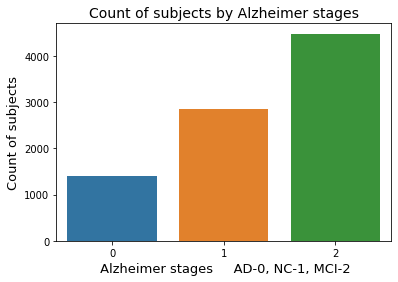

In [ ]:
sns.countplot(x='DX',data=Input_new)
plt.title('Count of subjects by Alzheimer stages', fontsize=14)
plt.ylabel('Count of subjects', fontsize=13)
plt.xlabel(' Alzheimer stages     AD-0, NC-1, MCI-2' , fontsize=13)

In [ ]:
Input_new['DX']=Input_new['DX'].astype('int')
Input_new['DX'].dtype
Input_new['AGE']=Input_new['AGE'].astype('int')
Input_new['AGE'].dtype
Input_new['PTGENDER']=Input_new['PTGENDER'].astype('int')
Input_new['PTGENDER'].dtype

dtype('int64')

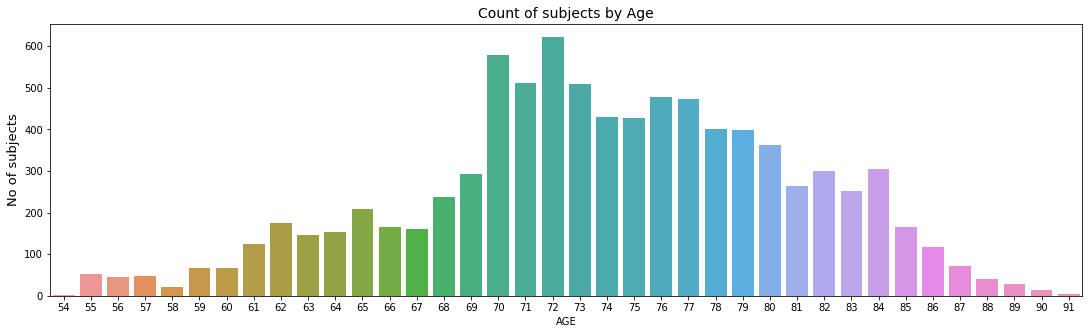

In [ ]:
ax = sns.countplot(x='AGE', data=Input_new)
ax.figure.set_size_inches(18.5, 5)
plt.title('Count of subjects by Age', fontsize=14)
plt.ylabel('No of subjects', fontsize=13)
plt.show()

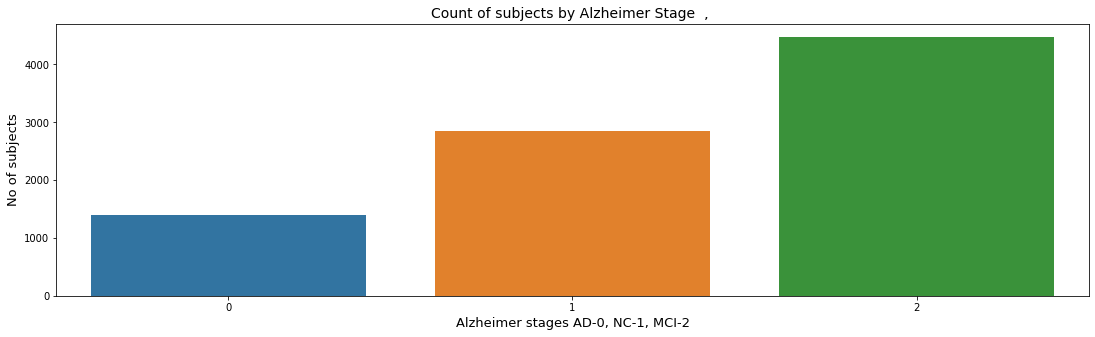

In [ ]:
ax = sns.countplot(x='DX', data=Input_new)
ax.figure.set_size_inches(18.5, 5)
plt.title('Count of subjects by Alzheimer Stage  , ', fontsize=14)
plt.ylabel('No of subjects', fontsize=13, )
plt.xlabel('Alzheimer stages AD-0, NC-1, MCI-2', fontsize=13)
plt.show()

###Violin Distribution plot

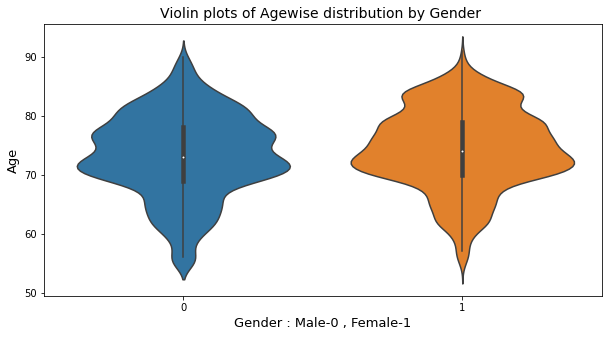

In [ ]:
# Plotting distribution
plt.figure(figsize=(10,5))
sns.violinplot(x='PTGENDER', y='AGE', data=Input_new)
plt.title('Violin plots of Agewise distribution by Gender ',fontsize=14)
plt.xlabel('Gender : Male-0 , Female-1',fontsize=13)
plt.ylabel('Age',fontsize=13)
plt.show()

In [ ]:
Input_new

,PTID_Key,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,FDG_bl,Years_bl,Month_bl,Month,M,EXAMDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,...,ST83TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST86SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST88SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST89SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST8SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST96SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST9SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,update_stamp_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
0,1.0,2010-12-10,81,1,13.0,1,6,1,1.0,1.50,14.00,21.00,27.0,28.0,3.0,3.0,50.00000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,2,2010-12-10,1.5,14.00,21.00,27.0,28.0,3.0,3.0,50.0000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,0.97265,0.000000,0.00000,0.0,0.0,355,...,2.858,0.911,808.0,274.0,2.435,0.549,6447.0,2768.0,2.079,0.689,86271.395895,3122.0,650.0,4.0,10571.0,4681.0,2.060,0.602,8067.0,2808.0,2.457,0.724,1829.0,722.0,2.457,0.941,8412.0,3696.0,1.929,0.652,5642.0,2293.0,2.460,0.764,13389.0,5166.0,2500.0,1.809,0.708,3490.0,1497.0,2.072,0.648,7240.0,2625.0,2.388,0.713,2385.0,73
1,1.0,2011-04-07,81,1,13.0,1,6,1,1.0,2.25,15.50,23.50,25.5,27.0,2.5,4.0,66.66665,3.0,30302.0,6314.0,909689.0,3635.0,14620.0,14899.0,1331790.0,2,2010-12-10,1.5,14.00,21.00,27.0,28.0,3.0,3.0,50.0000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,0.97265,0.323066,3.86885,3.0,3.0,905,...,2.689,0.889,909.0,269.0,2.794,0.524,7143.0,2758.0,2.260,0.716,86271.395895,3082.0,574.0,4.0,11647.0,4623.0,2.257,0.584,8174.0,2697.0,2.562,0.740,1750.0,743.0,2.347,0.862,8447.0,3667.0,2.009,0.619,5709.0,2137.0,2.516,0.733,13537.0,5073.0,2503.0,1.806,0.677,3802.0,1484.0,2.326,0.676,7461.0,2435.0,2.529,0.734,2195.0,73
2,1.0,2011-09-08,81,1,13.0,1,6,1,1.0,3.00,17.00,26.00,24.0,26.0,2.0,5.0,83.33330,5.0,31615.0,6345.0,9013

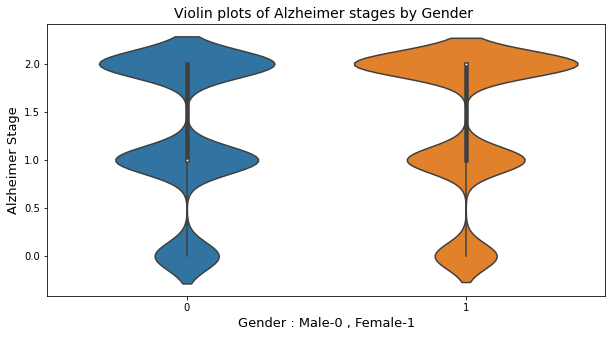

In [ ]:
# Plotting distribution
plt.figure(figsize=(10,5))
sns.violinplot(x='PTGENDER', y='DX', data=Input_new)
plt.title('Violin plots of Alzheimer stages by Gender ',fontsize=14)
plt.xlabel('Gender : Male-0 , Female-1',fontsize=13)
plt.ylabel('Alzheimer Stage',fontsize=13)
plt.show()

In [ ]:
Input_new.to_csv('/content/drive/My Drive/NCI /Alzheimer/data/Input_interp_filledCat_codedCat.csv',index=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
def scale(data):

    features=data.select_dtypes(exclude=["datetime"]).columns.tolist()
    # Separating out the features
    for feature in features:
    # Standardizing the features
        data[feature] = StandardScaler().fit_transform(data[feature].values.reshape(-1,1))
    
    return data
    

In [ ]:
data=Input_new.drop(['PTID_Key','EXAMDATE', 'EXAMDATE_bl','DX'], axis=1)
data.head()
df=scale(data)
df.shape

(8715, 710)

##Principle Componenet Analysis

In [ ]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)
y=pca.fit_transform(df)
principalDf = pd.DataFrame(data = y)
principalDf.shape

(8715, 278)

In [ ]:
pca.explained_variance_ratio_.cumsum()

array([0.18438902, 0.30051518, 0.34447562, 0.380791  , 0.4033759 ,
       0.42236095, 0.43893615, 0.45207163, 0.46465874, 0.47589474,
       0.48543713, 0.49481896, 0.50351565, 0.51191484, 0.51949141,
       0.52681548, 0.53394406, 0.54068045, 0.54725331, 0.55354576,
       0.55970464, 0.56560193, 0.5713725 , 0.57694411, 0.58242927,
       0.58759391, 0.59260483, 0.59747979, 0.60220353, 0.60682663,
       0.61135995, 0.61574445, 0.62000745, 0.62424576, 0.6284354 ,
       0.63256771, 0.63660553, 0.64050819, 0.64432428, 0.64801073,
       0.65168621, 0.65528196, 0.6588186 , 0.66234181, 0.66569352,
       0.66901683, 0.67224927, 0.67546218, 0.67860597, 0.68171604,
       0.68479767, 0.68786759, 0.69080978, 0.69370325, 0.69656238,
       0.6993635 , 0.70215725, 0.70490747, 0.70764169, 0.71034458,
       0.71302267, 0.71565561, 0.71826196, 0.72083916, 0.7233531 ,
       0.72583605, 0.72829546, 0.73069978, 0.73309834, 0.73548398,
       0.73785023, 0.74016296, 0.74246102, 0.7447392 , 0.74697

In [ ]:
Input_new.shape
principalDf=scale(principalDf)

In [ ]:
principalDf['PTID_Key']=Input_new['PTID_Key']
principalDf['EXAMDATE']=Input_new['EXAMDATE']
principalDf['DX']=Input_new['DX']
principalDf.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,PTID_Key,EXAMDATE,DX
0,-0.914627,-0.601258,-1.025954,0.646074,1.011304,0.545207,0.413025,0.157753,0.240323,1.241342,-0.615188,1.990854,0.508145,0.280259,0.153665,-0.378721,1.514711,-0.018951,0.283258,-0.657084,0.221393,0.350555,0.194970,-0.604919,-1.521198,-0.186426,-1.876618,-0.210861,0.673811,-0.596824,0.631972,0.027220,0.872613,-0.775025,0.768025,-1.076237,-0.941686,0.216097,2.490700,-1.265438,-0.277575,-1.353105,-0.388595,0.506031,-0.720210,-0.811336,-0.688113,0.742395,0.775106,...,-1.038844,-1.490284,0.324352,-1.028604,-0.972160,-0.283392,-1.045164,-0.832387,0.798486,0.210059,-0.449635,-0.441003,0.469078,-1.030184,-0.778918,0.415911,0.045974,0.320170,-2.414285,1.074156,2.614145,-1.760806,0.442195,0.431864,1.393142,-1.208740,0.603962,-1.974642,-1.248105,-0.304060,-0.846221,0.430196,0.793928,0.563909,0.624450,-0.352737,0.543500,-1.487216,1.264804,0.964885,-0.080049,1.064061,1.363676,1.058938,0.272191,-0.933477,1.0,2010-12-10,2
1,-0.551758,-0.979188,-1.117844,1.076659,0.625377,0.593831,0.200446,-0.109782,0.167414,1.085336,-0.908626,0.743372,0.728976,-0.158146,0.144664,0.512072,1.800080,-0.349467,0.228156,-0.650025,0.099217,0.732545,0.032123,-0.570181,-1.853058,0.309348,-1.390368,-0.525124,0.652957,0.002733,1.022216,-0.363548,1.138629,-0.807477,0.886634,-0.933278,-0.718929,-0.177979,1.806847,-0.246725,0.201150,-0.586490,-0.034705,1.524434,-0.490066,-0.777765,-0.901842,0.590897,0.483670,...,-1.341119,-0.416505,-0.392220,-1.099246,-1.542611,0.070696,-0.996193,-0.517035,0.528102,-0.645235,-0.807709,-0.870672,0.461747,-0.857624,-0.120386,0.090665,0.774271,0.565062,-1.341261,1.797199,1.253995,-0.440612,1.865252,-0.874564,1.139276,-1.714373,0.840345,-0.453060,-2.271202,0.701802,-1.159149,0.895165,0.005705,0.684127,0.605223,-0.346341,0.567335,-1.565463,1.082742,2.051711,-0.847921,-0.770229,0.627813,1.707643,-0.733248,-0.978921,1.0,2011-04-07,2
2,-0.819737,-0.982439,-1.010676,1.049898,0.690065,0.794359,0.281527,-0.584051,0.523014,1.314751,-0.469318,1.015452,0.096584,-0.088802,0.121028,0.640031,1.196030,-0.043073,0.300539,-0.511375,0.033300,0.266959,0.285403,-0.413766,-1.852933,0.159371,-1.505815,-0.257185,1.073447,-0.129415,0.114441,-0.491802,0.351462,-1.344000,0.941796,-1.608389,-0.638489,-0.208845,1.829999,-0.354246,0.138765,-1.168997,0.140994,1.355517,0.127256,-0.306865,-0.525544,0.153632,0.098746,...,-2.057672,-0.952390,0.817166,-0.929542,-1.253907,-0.757082,0.291924,0.301991,-0.853896,-0.014121,0.717416,0.330790,0.103781,-1.087737,0.104273,0.362352,-0.402443,0.103485,-1.247700,-0.150378,0.798621,-0.397531,1.220346,0.753486,0.668390,-0.309202,0.647125,-1.383107,-1.227107,-0.569572,-1.262420,-0.608105,0.859759,0.112846,1.038929,0.008226,0.399049,-0.651663,1.558614,0.498691,-0.013602,0.577223,0.193071,0.872848,0.810032,0.567605,1.0,2011-09-08,2
3,-1.336536,0.124959,0.264916,0.702107,-0.807134,0.915510,-0.873423,0.532419,-1.443437,0.450801,-0.561760,-0.045759,0.460943,-0.131770,0.077856,-0.862233,0.352317,-0.057771,-0.283949,-2.005893,-0.729035,-0.121274,0.386319,-0.724438,-0.163793,-0.482719,-0.054568,1.137994,-0.664942,-0.086511,0.020414,-0.143499,0.533670,-0.036038,0.685906,0.058562,-0.216113,-0.077563,0.045318,-0.706913,0.171094,0.184283,0.373552,-0.751905,0.778222,0.892420,-0.362174,-1.056220,0.453497,...,0.744001,-0.413096,-1.867010,-0.117463,-0.523031,1.244548,1.058056,-1.018938,0.014747,-0.899172,0.492322,0.230810,-0.515261,1.091011,-1.302503,-0.515504,-0.167311,-0.036739,0.137325,1.672527,-0.373430,-0.763381,0.547022,-0.613933,1.174471,-1.530746,-0.011245,-0.899292,0.415859,-0.510134,-0.333156,0.464144,1.131625,1.781166,-0.871261,0.403435,-0.576608,0.418030,2.221819,1.403739,0.146228,0.523462,-1.100993,0

###Exporting PCA dataset

In [ ]:
principalDf.to_csv('/content/drive/My Drive/NCI /Alzheimer/data/Input_pca_0.95thres.csv',index=False)

##Correlation Matrix

In [ ]:
# sort the correlation coefficients in descending order
def check_corr(data):
    c = data.corr().abs()

    s = c.unstack()
    so = s.sort_values(ascending=False).drop_duplicates()
    print(so)

In [ ]:
def del_corr(dataset, threshold):
    col_corr = [] # Set of all the names of deleted columns
    corr_matrix = dataset.corr().abs()
    print("Before deleting > ", threshold*100, "% correlated columns, the shape of the dataset is: ", dataset.shape)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.append(colname)
                proc_data=dataset.drop(col_corr,axis=1)
    print("After deleting > ", threshold*100, "% correlated columns, the shape of the dataset is: ", proc_data.shape)
    return proc_data
baseline_features = ['PTID_Key','EXAMDATE','Month','AGE','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','MMSE_bl','CDRSB_bl']
print(Input_new.shape)
data_toproc=Input_new.drop(baseline_features,axis=1)
print(data_toproc.shape)
Input_remove_corr=del_corr(data_toproc,0.7)
Input_remove_corr=pd.concat([Input_remove_corr, Input_new[baseline_features]], axis=1)
print(Input_remove_corr.shape)
Input_remove_corr.head()


(8715, 714)
(8715, 700)
Before deleting >  70.0 % correlated columns, the shape of the dataset is:  (8715, 700)
After deleting >  70.0 % correlated columns, the shape of the dataset is:  (8715, 382)
(8715, 396)


,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,CDRSB,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,DX,EXAMDATE_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,MidTemp_bl,FDG_bl,Years_bl,EXAMDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,VERSION_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,LONISID_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST101SV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST106CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST106TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST107CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST107TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST109CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,...,ST70SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST72SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST72TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST73SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST73TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST74SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST74TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST80SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST82SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST82TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST8SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,update_stamp_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,PTID_Key,EXAMDATE,Month,AGE,Hippocampus_bl,Ventricles_bl,WholeBrain_bl,ADAS13_bl,ICV_bl,FAQ_bl,RAVLT_immediate_bl,ADAS11_bl,MMSE_bl,CDRSB_bl
0,1,13.0,1,6,1,1.0,1.50,28.0,3.0,3.0,50.00000,30260.0,6288.0,904429.0,4081.0,14095.0,2,2010-12-10,3.0,3.0,14310.0,0.97265,0.000000,355,116,29568.000000,1399.000000,2661.000000,1240.000000,2.092000,0.569000,1457.000000,569.000000,0.678000,2825.000000,2.089000,0.558000,1748.000000,690.000000,2.208000,0.610000,3216.000000,0.568000,1393.000000,1.295000,6803.00000,3771.000000,0.611000,2303.000000,...,506.0,569.0,0.492,551.0,0.711,1694.0,0.659,1946.0,1290.0,0.436,551.0,2.858,0.911,808.0,2.435,0.549,0.689,4.0,10571.0,0.602,8067.0,0.724,722.0,0.941,3696.0,0.652,2293.0,2.460,0.764,1.809,0.708,0.648,2625.0,0.713,73,1.0,2010-12-10,0.0,81,6288.0,30260.0,904429.0,21.00,1328070.0,1.0,28.0,14.00,27.0,1.5
1,1,13.0,1,6,1,1.0,2.25,27.0,2.5,4.0,66.66665,30302.0,6314.0,909689.0,3635.0,14620.0,2,2010-12-10,3.0,3.0,14310.0,0.97265,0.323066,905,116,32565.000000,1392.00000

In [ ]:
Input_new.head()

,PTID_Key,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,FDG_bl,Years_bl,Month_bl,Month,M,EXAMDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,...,ST83TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST86SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST88SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST89SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST8SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST96SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST9SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,update_stamp_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
0,1.0,2010-12-10,81,1,13.0,1,6,1,1.0,1.50,14.00,21.00,27.0,28.0,3.0,3.0,50.00000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,2,2010-12-10,1.5,14.00,21.00,27.0,28.0,3.0,3.0,50.0000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,0.97265,0.000000,0.00000,0.0,0.0,355,...,2.858,0.911,808.0,274.0,2.435,0.549,6447.0,2768.0,2.079,0.689,86271.395895,3122.0,650.0,4.0,10571.0,4681.0,2.060,0.602,8067.0,2808.0,2.457,0.724,1829.0,722.0,2.457,0.941,8412.0,3696.0,1.929,0.652,5642.0,2293.0,2.460,0.764,13389.0,5166.0,2500.0,1.809,0.708,3490.0,1497.0,2.072,0.648,7240.0,2625.0,2.388,0.713,2385.0,73
1,1.0,2011-04-07,81,1,13.0,1,6,1,1.0,2.25,15.50,23.50,25.5,27.0,2.5,4.0,66.66665,3.0,30302.0,6314.0,909689.0,3635.0,14620.0,14899.0,1331790.0,2,2010-12-10,1.5,14.00,21.00,27.0,28.0,3.0,3.0,50.0000,1.0,30260.0,6288.0,904429.0,4081.0,14095.0,14310.0,1328070.0,0.97265,0.323066,3.86885,3.0,3.0,905,...,2.689,0.889,909.0,269.0,2.794,0.524,7143.0,2758.0,2.260,0.716,86271.395895,3082.0,574.0,4.0,11647.0,4623.0,2.257,0.584,8174.0,2697.0,2.562,0.740,1750.0,743.0,2.347,0.862,8447.0,3667.0,2.009,0.619,5709.0,2137.0,2.516,0.733,13537.0,5073.0,2503.0,1.806,0.677,3802.0,1484.0,2.326,0.676,7461.0,2435.0,2.529,0.734,2195.0,73
2,1.0,2011-09-08,81,1,13.0,1,6,1,1.0,3.00,17.00,26.00,24.0,26.0,2.0,5.0,83.33330,5.0,31615.0,6345.0,9013

In [ ]:
Correlated=Input_new[['PTID_Key', 'AGE', 'PTGENDER', 'PTMARRY', 'PTEDUCAT',  'Month', 'PTID_Key','EXAMDATE','DX','ADAS13','MMSE']]

In [ ]:
def plot_correlation_map( Input_new ):
    corr = Input_new.corr()
    _ , ax = plt.subplots( figsize =( 10 , 8 ) )
    cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
    _ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })

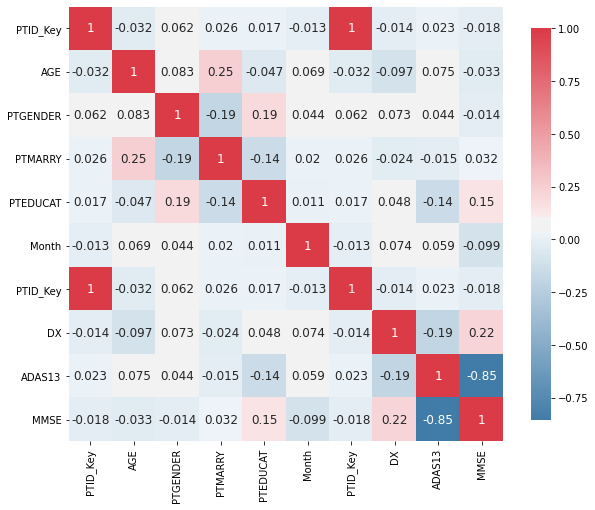

In [ ]:
plot_correlation_map(Correlated)

In [ ]:
Input_proc.to_csv('/content/drive/My Drive/NCI /Alzheimer/data/Input_remove_corr.csv',index=False)